In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import pims

import trackpy as tp
from IPython import display
%matplotlib inline

mpl.rc('figure',  figsize=(10, 10))

# Video analysis for supplementary Information
C = 0: green channel, HK. Generally less populated than
C = 1: red channel, Ald.

We are going to look at all videos and try to match particles and their trajectories.

The null hypothesis is that the trajectories are not correlated. What is the probability of observing the given data, if this is true?

## Step 1: locating the particles

We are going to look at individual frames to spot the particles and calibrate the parameters

In [ ]:
# loading the video data
frames_0 = pims.TiffStack("../stackdata/with glucose 2 - C=0.tif")
frames_1 = pims.TiffStack("../stackdata/with glucose 2 - C=1.tif")

In [ ]:
# our parameters
minmass = 60 # 60 for most, 150 for 20x objective
minsize = 5
separation = 20

In [ ]:
# locating the particles
f_0 = tp.locate(frames_0[0], minsize, minmass = minmass, separation = separation)
f_1 = tp.locate(frames_1[0], minsize, minmass = minmass, separation=separation)

In [ ]:
# looking at the first frame from Hexokinase
tp.annotate(f_0, frames_0[0]);

In [ ]:
# looking at the first frame from Aldolase
tp.annotate(f_1, frames_1[0]);

The results look good for this frame, now let's run this for the video.

In [ ]:
f_0 = tp.batch(frames_0, minsize, minmass=minmass, separation=separation)
f_1 = tp.batch(frames_1, minsize, minmass=minmass, separation=separation)

## Building trajectories
Same as before, we need to check the parameters to evaluate valid trajectories.

In [ ]:
skiphop = 10 # this is the numner of pixels a particle can jump between frames
mem = 5 # this is the number of frames that a particle can 'disappear' for
stubsize = 10 # the minium number of frames a trajectory has to exist for the trajectory to be considered

In [ ]:
# now we create the trajectories
t_0 = tp.link_df(f_0, skiphop, memory = mem)
t_1 = tp.link_df(f_1, skiphop, memory = mem)

In [ ]:
tl_0 = tp.filter_stubs(t_0, stubsize)
tl_1 = tp.filter_stubs(t_1, stubsize)

## Removing drift

In [ ]:
d = tp.compute_drift(tl_0) # we only compute drift for the 0 frame. 

In [ ]:
d.plot();

In the end we decide not to include drift because:
- some particles are completely immobile
- we are looking for correlated movement, and normalizing by the drift wouldn't either detract or help with the calculation of correlations

In [ ]:
# now we remove drift from both frames
tp.subtract_drift(tl_1, drift=d, inplace=True)
tp.subtract_drift(tl_0, drift=d, inplace=True)

## Visualizing the trajectories
Objectives:
- check that we are really looking at real trajectories
- see if there is a correlation with the other channel's particle
- think about how to show this for suppl. info

In [ ]:
# first let's see how many trajectories we are going to have to watch
traj_parts = [i for i in set(tl_0.particle) if len(tl_0[tl_0.particle ==i]) > 10]
len(traj_parts)

### Are the trajectories real? 
Use the code below to look at both the trajectories, and superpose with the other frame

In [ ]:
buff = 10 # the amount of space around the trajectory we want to vizualize

# for each trajectory
for no in traj_parts:
    # we clear the figure
    plt.clf();
    fig, ax = plt.subplots();
    
    # we filter the data according to ehe figure we want to look at
    x_traj =tl_0[tl_0.particle == no].x
    y_traj=tl_0[tl_0.particle == no].y
    
    # we determine the limits of the plots
    xmin, xmax = min(x_traj) - buff, max(x_traj) + buff
    ymin, ymax = min(y_traj) - buff, max(y_traj) + buff

    # this is the animation, for each frame in the trajectory
    for (i,_) in x_traj.iteritems():
        # ... we clear the axes
        plt.cla();
        # we show the background
        ax.imshow(frames_1[i]); # ***** change this *******
        
        # we set the limits to the plot according to what we computed earlier
        plt.xlim(xmin, xmax);
        plt.ylim(ymin, ymax);
        
        # we plot our trajectory
        ax.plot(x_traj,y_traj, color='red');
        display.display(plt.gcf());
        display.clear_output(wait=True);

    display.clear_output(wait=True);

### Showing this in graph form
We're happy that it works, now we show this using little graphs that can be put in the suppl!

In [ ]:
nplots = len(traj_parts)

nrows = int(nplots/3) +1
ncols = 3
buff = 10 # 10 for all but 2 for 2x
plt.figure(figsize=(15,15))
for j, part in enumerate(traj_parts):
    ax = plt.subplot(nrows, ncols, j+1)
    x_traj = tl_0[tl_0.particle == part].x
    y_traj = tl_0[tl_0.particle == part].y
    xlims = [np.min(x_traj)-buff, np.max(x_traj)+buff]
    
    ylims = [np.min(y_traj)-buff, np.max(y_traj)+buff]
    framelims = [tl_0[tl_0.particle ==part].iloc[1].frame,
                 tl_0[tl_0.particle ==part].iloc[-1].frame]
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.plot(x_traj, y_traj)
    # candidates
    cands = tl_1[(tl_1.frame >= framelims[0]) &
               (tl_1.frame <= framelims[1]) &
               (tl_1.x >= xlims[0]) &
               (tl_1.x <= xlims[1]) &
               (tl_1.y >= ylims[0]) &
               (tl_1.y <= ylims[1])]
    
    for candidate_particle in set(cands.particle):
        cand = cands[cands.particle == candidate_particle]
        ax.plot(cand.x, cand.y, color='red')
        

## Plotting the size distribution

In [ ]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.hist(f_0['mass'], bins=20);
# this is the appearance at t = 0

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
# this is the average appearance over the trajectory
tp.mass_size(tl_0.groupby('particle').mean());

## Iterating over the videos to build a DF.

In [3]:
import os

In [4]:
# getting a list of all the base filenames
root_filenames = []

for filename in os.listdir("../stackdata/"):
    if not filename.endswith("C=2.tif"):
        root_filenames.append(filename.split(' - ')[0])
        
root_filenames = set(root_filenames)

print root_filenames

set(['l-glu_001', 'with glucose 4 but have flow', 'with glucose with 20X objective', 'with glucose 5', 'with glucose 2', 'with glucose 3', 'no glucose', 'L-glucose', 'no glucose 2', 'l-glu'])


In [18]:
# now for each filename, we load a pair of videos
# and run them through everything
aggregate_df = pd.DataFrame()

for root_filename in list(root_filenames):
    print "working on file: " + root_filename + "\n"
    # load files
    frames_0 = pims.TiffStack("../stackdata/" + root_filename + " - C=0.tif")
    frames_1 = pims.TiffStack("../stackdata/" + root_filename + " - C=1.tif")
    
    # setting the parameters
    if "20x" in root_filename:
        minmass = 150
        minsize = 5
        separation = 20
        buff = 2
    else:
        minmass = 60
        minsize = 5
        separation = 20
        buff = 10 # 10 for all but 2 for 2x
    
    # locating the features
    f_0 = tp.batch(frames_0, minsize, minmass=minmass, separation=separation)
    f_1 = tp.batch(frames_1, minsize, minmass=minmass, separation=separation)

    skiphop = 10 # this is the numner of pixels a particle can jump between frames
    mem = 5 # this is the number of frames that a particle can 'disappear' for
    stubsize = 10 # the minium number of frames a trajectory has to exist for the trajectory to be consideredoO

    # linking trajectories
    t_0 = tp.link_df(f_0, skiphop, memory = mem)
    t_1 = tp.link_df(f_1, skiphop, memory = mem)

    tl_0 = tp.filter_stubs(t_0, stubsize)
    tl_1 = tp.filter_stubs(t_1, stubsize)

    # number of trajectories in the frame of interest
    traj_parts = [i for i in set(tl_0.particle) if len(tl_0[tl_0.particle ==i]) > 10]
    
    n_traj = len(traj_parts)
    
    for j, part in enumerate(traj_parts):
        # our main dataframe
        df_0 = tl_0[tl_0.particle == part]
        # this is our 'main' trajectory
        x_traj = df_0.x
        y_traj = df_0.y
        
        # this is the frame around our trajectory
        xlims = [np.min(x_traj)-buff, np.max(x_traj)+buff]
        ylims = [np.min(y_traj)-buff, np.max(y_traj)+buff]
        framelims = [df_0.iloc[1].frame,
                     df_0.iloc[-1].frame]
        
        # candidate data frame
        cands = tl_1[(tl_1.frame >= framelims[0]) &
                   (tl_1.frame <= framelims[1]) &
                   (tl_1.x >= xlims[0]) &
                   (tl_1.x <= xlims[1]) &
                   (tl_1.y >= ylims[0]) &
                   (tl_1.y <= ylims[1])]
        
        # now we find the longest candidate trajectory
        length_traj = 0
        chosen_particle = None
        for candidate_particle in set(cands.particle):
            cand = cands[cands.particle == candidate_particle]
            if len(cand) > length_traj:
                chosen_particle = candidate_particle
                length_traj = len(cand)
                
        df_1 = cands[cands.particle == chosen_particle]
        
        # now we add some name fields and concatenate the things
        df_0['filename'] = root_filename
        df_1['filename'] = root_filename
        df_0['channel'] = 0
        df_1['channel'] = 1
        df_0['pair_id'] = j
        df_1['pair_id'] = j
        
        aggregate_df = pd.concat([aggregate_df, df_0, df_1])
        
            


Frame 169: 19 trajectories present


In [19]:
aggregate_df.to_csv("../data/trajectory_df.csv")

In [11]:
list(root_filenames)[4:5]
testname = list(set(aggregate_df.filename))[0]
testname

'with glucose 2'

In [12]:
ha = aggregate_df[aggregate_df.filename == testname] 
ha_0 = ha[ha.channel ==0]
ha_1 = ha[ha.channel == 1]

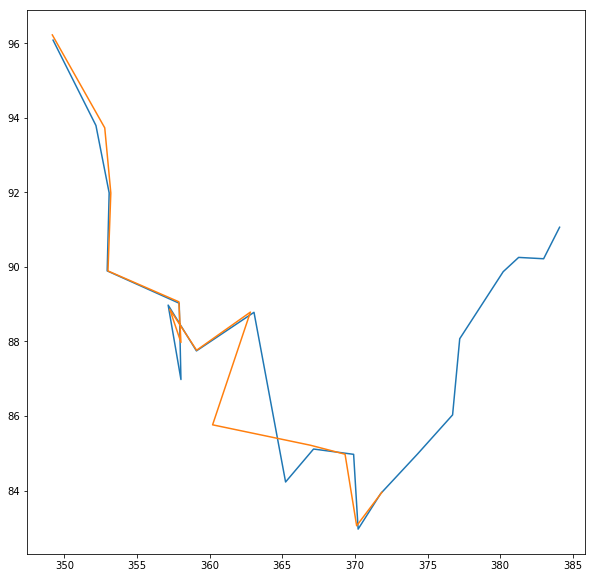

In [17]:
pair_id = 0
test_0 = ha_0[ha_0.pair_id == pair_id]
test_1 = ha_1[ha_1.pair_id == pair_id]
fig, ax = plt.subplots()
ax.plot(test_0.x, test_0.y)
ax.plot(test_1.x, test_1.y)